# Load Data

In [1]:
%matplotlib inline
from data import get_mnist_dataloaders

from diffusion.transition import (
    linear_beta_schedule,
    build_all_transition_matrices,
    compute_cumulative_transition_matrices,
    sample_q_xt_given_x0,
    compute_discrete_posterior
)

from models.simple_mlp import SimpleD3PMMLP
from diffusion.transition import sample_q_xt_given_x0, compute_discrete_posterior
from diffusion.reverse import compute_p_theta_xtminus1_given_xt_from_p_tilde

from training.train_one_epoch import train_one_epoch
from training.trainer import Trainer

import torch
import torch.nn.functional as F


In [2]:
device = 'cuda'

In [3]:
train_loader, test_loader = get_mnist_dataloaders(
    batch_size=32,
    train_subset_size=10000,
    test_subset_size=200,
    data_root="./data",
    threshold=0.5
)

In [4]:
# Shape is (batch_size, channels, height, width)
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [5]:
# Black or white pixels rather than greyscale
print(torch.unique(x))

tensor([0, 1])


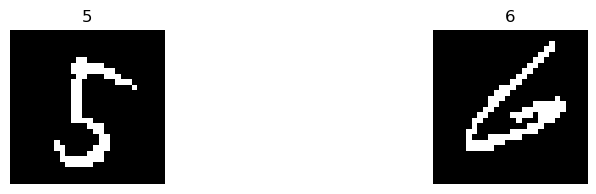

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(x[i].squeeze(), cmap="gray", vmin=0, vmax=1)
    plt.title(y[i].item())
    plt.axis("off")
plt.show()

# Define Transition Matrix for noising

In [7]:
T = 100

betas = linear_beta_schedule(T).to(device)
Qs = build_all_transition_matrices(betas).to(device)

print(betas.shape)   # torch.Size([100])
print(Qs.shape)      # torch.Size([100, 2, 2])
print(Qs[0])
print(Qs[T-1])

torch.Size([100])
torch.Size([100, 2, 2])
tensor([[9.9990e-01, 1.0000e-04],
        [1.0000e-04, 9.9990e-01]], device='cuda:0')
tensor([[0.5000, 0.5000],
        [0.5000, 0.5000]], device='cuda:0')


In [8]:
# Define Qbar[t] = Q_1 * Q_2 * ... * Q_t
Qbar = compute_cumulative_transition_matrices(Qs, device=device)   # [T,2,2]

In [9]:
print("Qbar[2]:\n", Qbar[1])
print("Qbar[T]:\n", Qbar[T-1])

Qbar[2]:
 tensor([[0.9948, 0.0052],
        [0.0052, 0.9948]], device='cuda:0')
Qbar[T]:
 tensor([[0.5000, 0.5000],
        [0.5000, 0.5000]], device='cuda:0')


# Noise Data and Visualise

In [10]:
x[0].shape

torch.Size([1, 28, 28])

In [11]:
timesteps = [0, 5, 10, 20, 40, 80, T-1]

results = []   # list of [(t, x_t_batch)]

for t in timesteps:
    xt_batch = sample_q_xt_given_x0(x, t=t, Qbar=Qbar)
    results.append((t, xt_batch.cpu()))

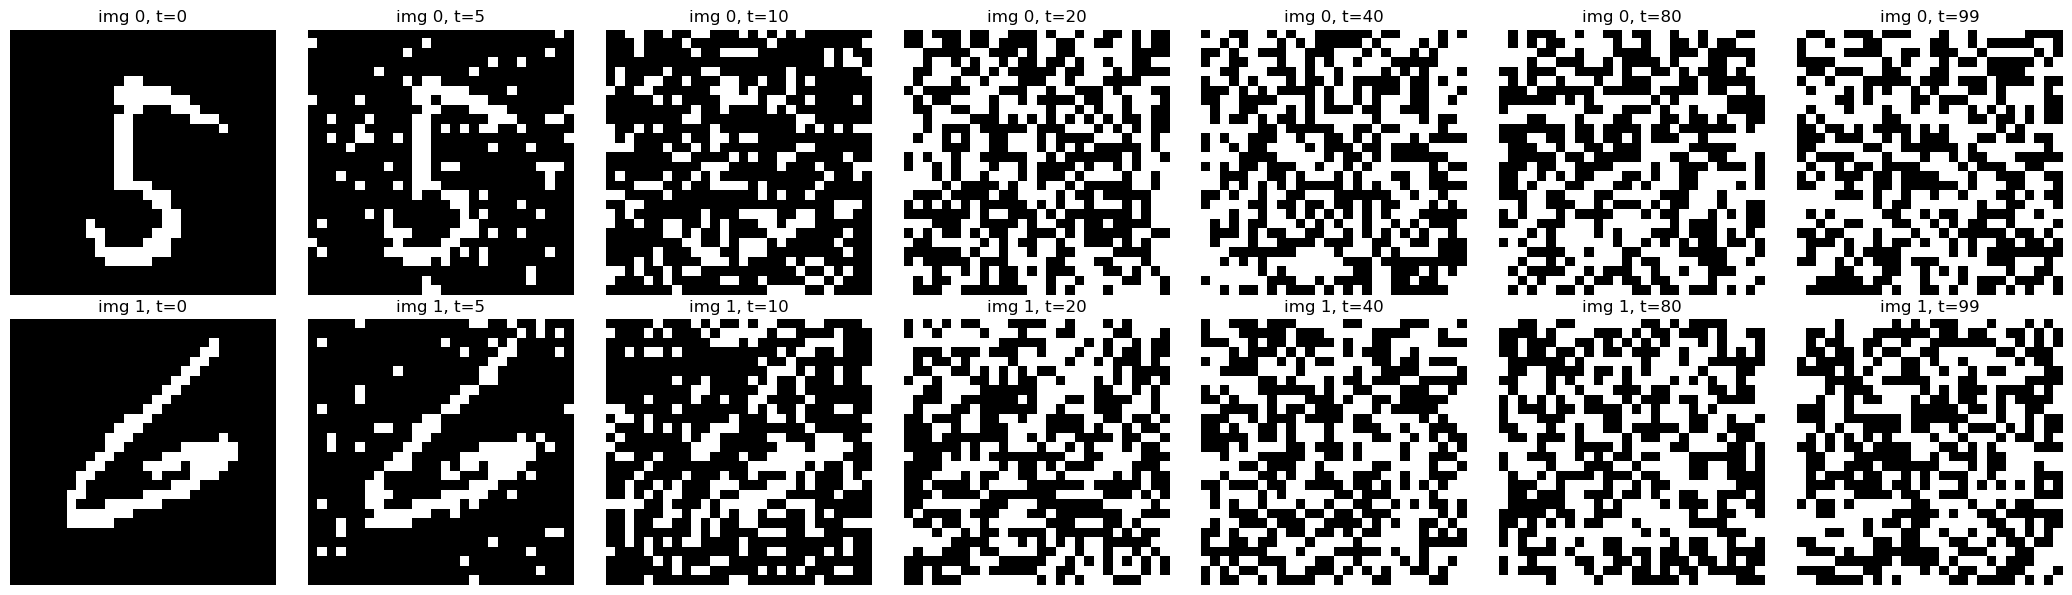

In [12]:
num_images = 2       # = 2
num_steps = len(timesteps)

plt.figure(figsize=(3 * num_steps, 3 * num_images))

for img_idx in range(num_images):  # loop over images in the batch
    for step_idx, (t, xt_batch) in enumerate(results):
        plt.subplot(num_images, num_steps, img_idx * num_steps + step_idx + 1)
        plt.imshow(xt_batch[img_idx].squeeze(), cmap="gray", vmin=0, vmax=1)
        plt.title(f"img {img_idx}, t={t}")
        plt.axis("off")

plt.tight_layout()
plt.show()

In [13]:
# Compute posterior Q(x_{t-1} | x_t, x_0) for t=99
t = 30   # random example
xt = sample_q_xt_given_x0(x, t=t, Qbar=Qbar)


q_posterior = compute_discrete_posterior(xt, x, t=t, Qs=Qs, Qbar=Qbar)

In [14]:
q_posterior.shape # (batch_size, channels, height, width, num_classes)

torch.Size([32, 1, 28, 28, 2])

In [15]:
# Example: get posterior distribution at pixel (2, 2) of first image in batch
q_posterior[0, 0, 2, 2]

tensor([0.8503, 0.1497], device='cuda:0')

# Initialize model to predict posterior

In [16]:
model = SimpleD3PMMLP(T=T).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
x = x.to(device)
t = torch.randint(1, T, (x.shape[0],), device=device)   # shape [B]

In [18]:
xt = sample_q_xt_given_x0(x, t, Qbar).to(device)        # [B,1,28,28]

In [19]:
# this is p̃_theta(x0 | x_t))
logits_x0 = model(xt, t).to(device)

In [20]:
# compute eqn (4)
p_theta = compute_p_theta_xtminus1_given_xt_from_p_tilde(logits_x0, xt, t, Qs, Qbar)   

In [21]:
# KL divergence between q_posterior and p_theta
log_q = torch.log(q_posterior + 1e-20)
log_p = torch.log(p_theta + 1e-20)
kl = (q_posterior * (log_q - log_p)).sum(dim=-1).mean()

In [22]:
# auxilary term is CE
p_tilde = F.softmax(logits_x0, dim=1).to(device)         # [B,2,28,28]
p_x0 = p_tilde.gather(1, x)                  # [B,1,28,28]
aux_ce = -(torch.log(p_x0 + 1e-20)).mean()

In [23]:
lambda_aux = 0.1  # (arbitraty)
loss = kl + lambda_aux * aux_ce

loss

tensor(0.7132, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
# # ----- 10. Backprop + optimizer step -----
optimizer.zero_grad()
loss.backward()
optimizer.step()

print(f"loss={loss.item():.4f}, kl={kl.item():.4f}, aux_ce={aux_ce.item():.4f}, t_mean={t.float().mean().item():.1f}")

loss=0.7132, kl=0.6429, aux_ce=0.7036, t_mean=46.6


# Use a trainer to call train_one_epoch internally

In [19]:
model = SimpleD3PMMLP(T=T).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

In [20]:
# Create trainer
trainer = Trainer(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=test_loader,   # optional
    Qs=Qs,
    Qbar=Qbar,
    T=T,
    device=device,
    ckpt_dir="./training/checkpoints"
)


Epoch 1/10
  loss: 0.0076
  kl: 0.0069
  aux_ce: 0.6863
  steps: 313.0000
  val_aux_ce: 0.6678


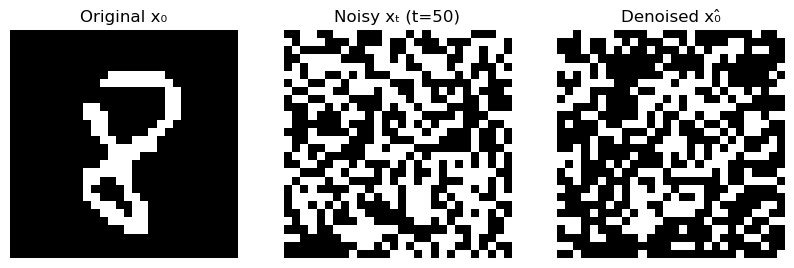

  denoise_acc_t50: 0.6107

Epoch 2/10
  loss: 0.0071
  kl: 0.0064
  aux_ce: 0.6498
  steps: 313.0000
  val_aux_ce: 0.6310


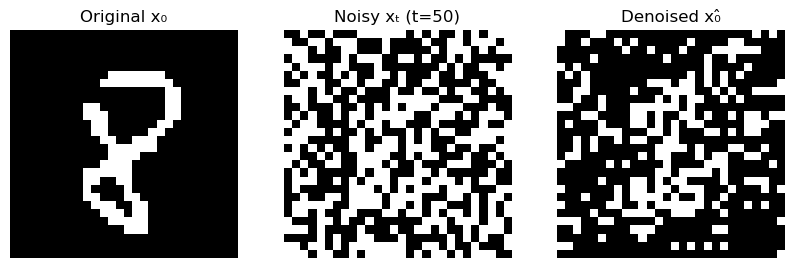

  denoise_acc_t50: 0.6942

Epoch 3/10
  loss: 0.0067
  kl: 0.0061
  aux_ce: 0.6112
  steps: 313.0000
  val_aux_ce: 0.5888


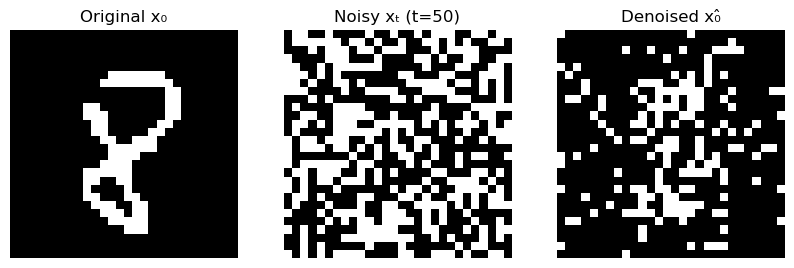

  denoise_acc_t50: 0.7604

Epoch 4/10
  loss: 0.0063
  kl: 0.0058
  aux_ce: 0.5676
  steps: 313.0000
  val_aux_ce: 0.5414


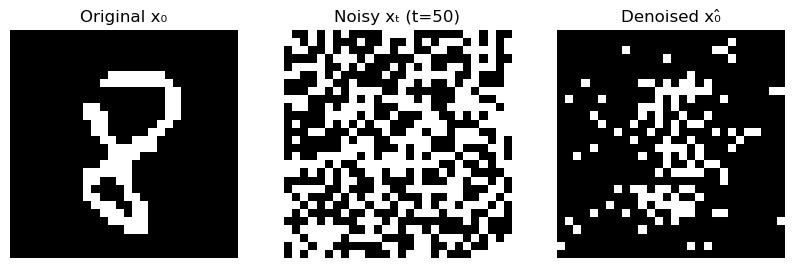

  denoise_acc_t50: 0.8079

Epoch 5/10
  loss: 0.0058
  kl: 0.0053
  aux_ce: 0.5192
  steps: 313.0000
  val_aux_ce: 0.4925


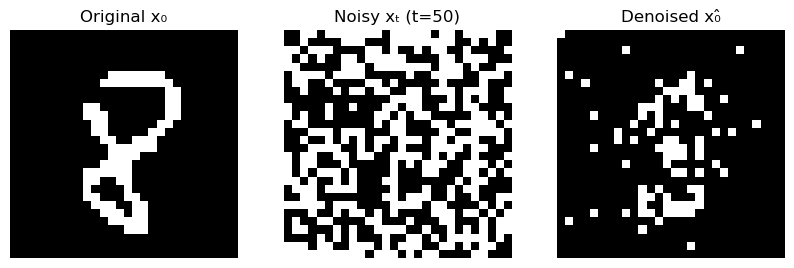

  denoise_acc_t50: 0.8396

Epoch 6/10
  loss: 0.0052
  kl: 0.0047
  aux_ce: 0.4720
  steps: 313.0000
  val_aux_ce: 0.4467


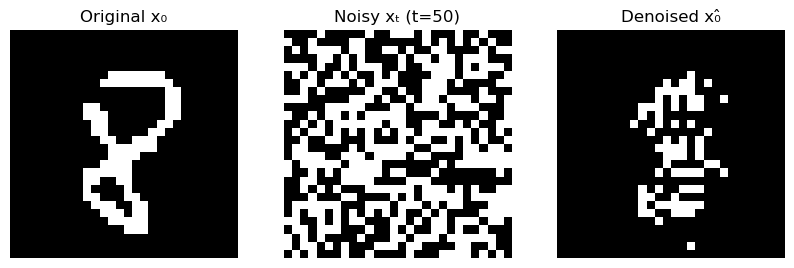

  denoise_acc_t50: 0.8502

Epoch 7/10
  loss: 0.0051
  kl: 0.0047
  aux_ce: 0.4269
  steps: 313.0000
  val_aux_ce: 0.4069


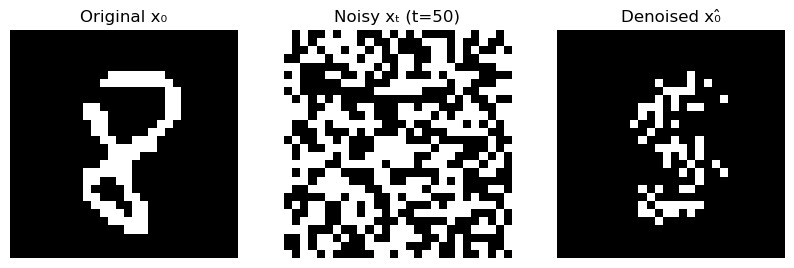

  denoise_acc_t50: 0.8642

Epoch 8/10
  loss: 0.0046
  kl: 0.0042
  aux_ce: 0.3875
  steps: 313.0000
  val_aux_ce: 0.3668


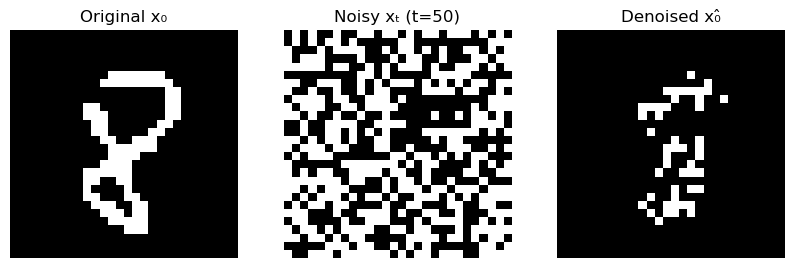

  denoise_acc_t50: 0.8609

Epoch 9/10
  loss: 0.0042
  kl: 0.0039
  aux_ce: 0.3580
  steps: 313.0000
  val_aux_ce: 0.3410


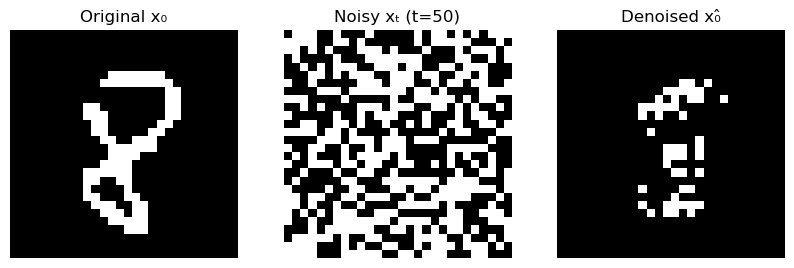

  denoise_acc_t50: 0.8675

Epoch 10/10
  loss: 0.0039
  kl: 0.0036
  aux_ce: 0.3365
  steps: 313.0000
  val_aux_ce: 0.3204


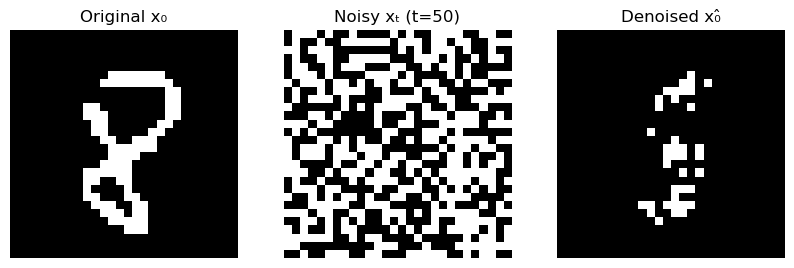

  denoise_acc_t50: 0.8587


In [21]:
history = trainer.train(num_epochs=10, save_every=None, validate=True, print_every=1)